In [1]:
import os
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import torchvision
import PIL
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

In [2]:
root_folder = "training_data2"
fen_souce_folder = "E:\web\data"

In [3]:
label2piece = {"0":"b","1":"k","2":"n","3":"p","4":"q","5":"r","6":"B","7":"K","8":"N","9":"P","10":"Q","11":"R","12":"z"}
piece2label = {item[1]:item[0] for item in label2piece.items()}

In [4]:
book_data = pd.read_csv("E:\\web\\tactics2001\\data\\book.csv")
data_dict =  book_data.to_dict('records')

In [5]:
def conv3x3(in_channels, out_channels, **kwargs):
    # The convolutional layers (for feature extraction) use standard layers from
    # `torch.nn`, since they do not require adaptation.
    # See `examples/maml/model.py` for comparison.
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        nn.BatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [6]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = nn.Sequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        # Only the last (linear) layer is used for adaptation in ANIL
        self.classifier = torch.nn.Linear(hidden_size, out_features)

    def forward(self, inputs, params=None):
        features = self.features(inputs)
        # print(features.shape)
        features = torch.mean(features.view(features.size(0), features.size(1), - 1), dim = -1)
        # print(features.shape)
        
        logits = self.classifier(features)
        return logits


In [7]:
model = ConvolutionalNeuralNetwork(1, 13)

In [8]:
a = torch.randn(10,1,64,64)

In [9]:
def parseImageFEN(image_folder, fen):
    fen_main = fen.split(" ")[0]
    piece_matrix = []
    for line in fen_main.split("/"):
        piece_line = []
        position = 0
        for c in line:
            if not c.isdigit():
                piece_line.append(piece2label[c])
                position += 1
            else:
                for i in range(int(c)):
                    piece_line.append(piece2label["z"])
                    position += 1
        piece_matrix.append(piece_line)
    
    label_list = []
    image_list = []
    
    for image in os.listdir(image_folder):
        num = int(image.split("s")[0])
        x = num % 8
        y = num // 8
        label = piece_matrix[x][y]
        image_full_path =os.path.join(image_folder, image)
        label_list.append(label)
        image_list.append(image_full_path)
        
    return image_list,label_list

In [10]:
class ChessDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_path, transform_style=None):
        'Initialization'
        self.data_path = data_path
        self.labels = []
        self.image_list = []
        
        self.load_image_list()
        self.transform_style = transform_style
        
    def load_image_list(self):
        for i, image_folder in enumerate(os.listdir(self.data_path)):
            image_folder_path = os.path.join(self.data_path, image_folder)
            print(i,image_folder)
            for j, image in enumerate(os.listdir(image_folder_path)):
                if j > 20:
                    break
                image_path = os.path.join(image_folder_path, image)
                self.image_list.append(image_path)
                self.labels.append(i)
                
    def load_addtional_data(self):
        for image_folder in os.listdir(fen_souce_folder):
            for data_item in data_dict:
                if image_folder == str(data_item["no"]):
                    print(data_item["no"], data_item["FEN"])
                    images_add, labels_add = parseImageFEN(os.path.join(fen_souce_folder, image_folder),data_item["FEN"])
                    for i in range(len(images_add)):
                        self.image_list.append(images_add[i])
                        self.labels.append(int(labels_add[i]))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        single_image_path = self.image_list[index]
        # Open image
        X = PIL.Image.open(single_image_path).convert("L")
        #X = PIL.ImageOps.invert(img)
        if self.transform_style:
            X = self.transform_style(X)
        
        y = self.labels[index]

        return X, y

In [11]:
import torchvision.transforms.functional as TF
import random
from typing import Sequence

class MyRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

In [12]:
my_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    MyRotateTransform([0,90,180,270]),
    torchvision.transforms.ToTensor(),
])

In [13]:
cd = ChessDataset("training_data/",my_transforms)

0 bB
1 bK
2 bN
3 bP
4 bQ
5 bR
6 wB
7 wK
8 wN
9 wP
10 wQ
11 wR
12 zbackground


In [14]:
len(cd)

225

In [15]:
cd.load_addtional_data()

470 r1bqrbk1/5p1p/2pp2nB/pp5Q/4P3/PBNPR2P/1P4P1/R5K1 w - - 0 1
472 r1bqr1k1/1p1nnpb1/p5pp/2P1p1B1/B3N3/5N2/P4PPP/2RQR1K1 w - - 0 1
473 r1bqr1k1/pp3ppp/2n5/2bp4/3N1Pn1/1BP5/PP2N1PP/R1BQ1RK1 b - - 0 1
474 r4rk1/pp1n1q1p/2pbn1p1/3p2P1/3P2BN/1P2P3/PBQ2P2/2KR3R w - - 0 1
475 r2q1rk1/1ppb1ppp/3p1n2/2PPp3/PB2Pn2/2NB4/5PPP/R2Q1RK1 b - - 0 1
476 r2n1rk1/3qb1pp/p2p4/1p1bpP2/1P6/P2BBN1P/5PP1/2RQR1K1 w - - 0 1
477 r1br2k1/pp1qppbp/1nn5/1Np1Pp2/4B3/2P2N2/PP2Q1PP/R1B2RK1 w - - 0 1


In [16]:
print(len(cd))

673


457
torch.Size([1, 64, 64])
P


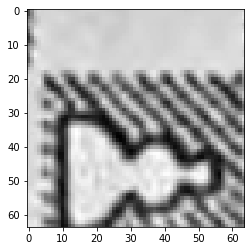

In [17]:
random_index =np.random.randint(0, len(cd))
plt.imshow(cd[random_index][0][0],cmap="gray")
print(random_index)
print(cd[random_index][0].shape)
print(label2piece[str(cd[random_index][1])])

In [18]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def focal_loss(input_values, gamma):
    """Computes the focal loss"""
    p = torch.exp(-input_values)
    loss = (1 - p) ** gamma * input_values
    return loss.mean()

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.):
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        return focal_loss(F.cross_entropy(input, target, reduction='none', weight=self.weight), self.gamma)

class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

In [19]:
train_dataset_len = int(0.8 * len(cd))
test_dataset_len = len(cd) - train_dataset_len

In [20]:
train_dataset, test_dataset = torch.utils.data.random_split(cd,[train_dataset_len, test_dataset_len])

In [21]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
epochs = 100

In [31]:
loss_fun = FocalLoss(gamma=2)

In [32]:
def get_accuracy(logits, targets):
    """Compute the accuracy (after adaptation) of MAML on the test/query points

    Parameters
    ----------
    logits : `torch.FloatTensor` instance
        Outputs/logits of the model on the query points. This tensor has shape
        `(num_examples, num_classes)`.

    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(num_examples,)`.

    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points
    """
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

In [ ]:
for epoch in range(epochs):
    loss_epoch_train = []
    acc_epoch_train = []
    acc_epoch_test = []
    count = 0
    model.train()
    for batch_inputs, batch_targets in tqdm(train_dataloader):
        #print(batch_inputs.shape)
#         if torch.cuda.is_available():
#             batch_inputs = batch_inputs.to("cuda")
#             batch_scores = batch_scores.to("cuda")
        
        #plt.imshow(batch_inputs[0][0],cmap="gray")
        #plt.show()
        
    
        batch_preds = model(batch_inputs)
        
        loss = loss_fun(batch_preds, batch_targets)
        #print(batch_preds, batch_targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_epoch_train.append(loss.item())
        acc = get_accuracy(batch_preds, batch_targets).item()
        #print("acc", acc)
        
        acc_epoch_train.append(acc)
    
    print("epoch: {} avg loss train {:.2f} acc {:.2f} ".format(epoch, np.mean(loss_epoch_train), np.mean(acc_epoch_train)))
        
    model.eval()
    for batch_inputs, batch_targets in tqdm(test_dataloader):
        batch_preds = model(batch_inputs)
        acc = get_accuracy(batch_preds, batch_targets).item()
        acc_epoch_test.append(acc)
        
    print("epoch: {} avg acc test {:.2f} ".format(epoch, np.mean(acc_epoch_test)))


epoch: 0 avg loss train 1.12 acc 0.55 



epoch: 0 avg acc test 0.55 



epoch: 1 avg loss train 0.93 acc 0.62 



epoch: 1 avg acc test 0.53 



epoch: 2 avg loss train 0.80 acc 0.67 



epoch: 2 avg acc test 0.64 



epoch: 3 avg loss train 0.74 acc 0.69 



epoch: 3 avg acc test 0.62 



epoch: 4 avg loss train 0.61 acc 0.70 



epoch: 4 avg acc test 0.65 



epoch: 5 avg loss train 0.53 acc 0.75 



epoch: 5 avg acc test 0.67 



epoch: 6 avg loss train 0.47 acc 0.78 



epoch: 6 avg acc test 0.68 


In [27]:
label2piece = {"0":"bB","1":"bK","2":"bN","3":"bP","4":"bQ","5":"bR","6":"wB","7":"wK","8":"wN","9":"wP","10":"wQ","11":"wR","12":"zbackground"}

508
12
tensor([[-0.2728, -0.4500, -0.9056,  0.3927, -1.0766, -0.2730, -0.5441, -0.5460,
         -0.8145,  0.5503, -0.8172, -0.2300,  1.0261]],
       grad_fn=<AddmmBackward>)
zbackground


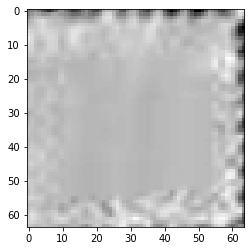

In [28]:
random_index = np.random.randint(len(cd))
print(random_index)
plt.imshow(cd[random_index][0][0],cmap="gray")
print(cd[random_index][1])
output = model(cd[random_index][0].unsqueeze(0))
print(output)
print(label2piece[str(torch.argmax(output, dim=1).item())])

In [29]:
#torch.save(model.state_dict(), "2_5_2021.pth")